In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import harmonypy
import pymn
import scrublet as scr
import gseapy as gp
from gseapy.plot import barplot, dotplot
import bottleneck
import pyreadr
from scipy.io import mmread
import scipy
from sklearn import preprocessing
import random as rd
import scib
from matplotlib_venn import venn2,venn2_circles,venn3
from pyscenic.export import export2loom, add_scenic_metadata
from sklearn.decomposition import NMF
from sklearn import metrics
import palettable
from pyscenic.rss import regulon_specificity_scores
import matplotlib.image as mpimg
import cosg as cosg
from pySankey.sankey import sankey

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/pyMetaNeighbor-0.1.0-py3.9.egg/pymn/trainModel.py:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/pyMetaNeighbor-0.1.0-py3.9.egg/pymn/trainModel.py:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
Error: package or namespace load failed for 'methods' in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/public/home/guogjgroup/ggj/anaconda3/envs/R3.6/lib/R/library/methods/libs/methods.so':
  libR.so: cannot open shared object file: No such file or directory
During startup - Warning messages:
1: package 'methods' was built under R version 3.6.3 
2: package "methods" in options("defaultPackages") was not found 
3: package 'datasets' was built under R version 3.6.3 
4: package 'grDevices' was built under R version 3.6.3 
5: package 'graphics' was built under R version 3.6.3 
6: package 'methods' was built under

In [2]:
sc.set_figure_params(dpi = 200, color_map = 'viridis_r' )
sc.settings.verbosity = 2

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


# Cell Cycle Gene Name

In [108]:
def gene_name_in_gtf(query_list):
    
    import numpy as np
    import pandas as pd
    
    gene_alias_latest=pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/hh_seq_annotation/gene_alias.csv', index_col=0)
    gene_alias_latest=gene_alias_latest.fillna('0')
    gene_alias_latest['alias']=gene_alias_latest.astype(str)
    
    query_result=pd.DataFrame(index=query_list, columns=['name_in_gtf'])
    query_result['name_in_gtf']='Not_Found'

    for i in query_list:

        if [s for s in gene_alias_latest.index.tolist() if i == s]!=[]:
            query_result.loc[i,'name_in_gtf']=i

        elif [s for s in gene_alias_latest['alias'].tolist() if i in s]==[] and [s for s in gene_alias_latest.index.tolist() if i == s]==[]:
            continue

        elif [s for s in gene_alias_latest['alias'].tolist() if i in s]!=[] and [s for s in gene_alias_latest.index.tolist() if i == s]==[]:
            query_gene_column=[s for s in gene_alias_latest['alias'].tolist() if i in s]
            query_gene_subset=gene_alias_latest[gene_alias_latest['alias'].isin(query_gene_column)]
            query_gene_subset=query_gene_subset['alias'].str.split('|', expand=True)
            query_gene_subset=query_gene_subset.fillna('0')
            if query_gene_subset.shape[0]==1 and [s for s in np.unique(query_gene_subset.values).tolist() if i == s]!=[]:
                query_result.loc[i,'name_in_gtf']=''.join(query_gene_subset.index.tolist())
            elif query_gene_subset.shape[0]>1 and [s for s in np.unique(query_gene_subset.values).tolist() if i == s]!=[]:
                for each_row in query_gene_subset.index.tolist():
                    if [s for s in query_gene_subset.loc[each_row,:].tolist() if i == s]==[]:
                        query_gene_subset=query_gene_subset.drop(each_row)
                if query_gene_subset.shape[0]==0:
                    continue
                elif query_gene_subset.shape[0]>1:
                    query_result.loc[i,'name_in_gtf']='Ambiguous'
                elif query_gene_subset.shape[0]==1:
                    query_result.loc[i,'name_in_gtf']=''.join(query_gene_subset.index.tolist())
    print(query_result)
    query_result.to_csv('query_result.csv')

In [109]:
cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]

/tmp/ipykernel_24408/1257472916.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt' mode='r' encoding='UTF-8'>
  cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]


In [110]:
gene_name_in_gtf(cell_cycle_genes)

       name_in_gtf
MCM5          MCM5
PCNA          PCNA
TYMS          TYMS
FEN1          FEN1
MCM2          MCM2
...            ...
NEK2          NEK2
G2E3          G2E3
GAS2L3      GAS2L3
CBX5          CBX5
CENPA        CENPA

[97 rows x 1 columns]


In [111]:
query_result = pd.read_csv('query_result.csv', index_col=0)

In [112]:
query_result['equal'] = 'N'

for i in query_result.index.tolist():
    
    if i == query_result.loc[i, 'name_in_gtf']:
        
        query_result.loc[i, 'equal'] = 'Y'
        
query_result[query_result['equal'] != 'Y']

,name_in_gtf,equal
MLF1IP,CENPU,N


In [113]:
cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

/tmp/ipykernel_24408/1167548311.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt' mode='r' encoding='UTF-8'>
  cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]


In [114]:
[s for s in s_genes if 'MLF1IP' in s]

['MLF1IP']

In [115]:
[s for s in g2m_genes if 'MLF1IP' in s]

[]

In [116]:
[s for s in s_genes if 'CENPU' in s]

[]

In [117]:
[s for s in g2m_genes if 'CENPU' in s]

[]

# Cell Cycle: Combined DGE

In [146]:
subset_name = 'combined_DGE'

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/endothelial_cell/adata_all_endo_cell_sct_annotation_latest.h5ad')
adata = adata[adata.obs['leiden'] == '12']
adata_1 = adata.copy()

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cnv_high_epi_harmony_anno_latest.h5ad')
adata = adata[adata.obs['leiden'] == '6']
adata_2 = adata.copy()

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/myeloid_cell/adata_all_monocyte_sct_annotation_latest.h5ad')
adata = adata[adata.obs['leiden'].isin(['13', '18'])]
adata_3 = adata.copy()

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_low_epi_harmony/cnv_low_epi_harmony_anno_latest.h5ad')
adata = adata[adata.obs['leiden'].isin(['9'])]
adata_4 = adata.copy()

adata_cycle = sc.AnnData.concatenate(adata_1, adata_2, adata_3, adata_4,
                                     join = "outer", fill_value = 0, index_unique = None)

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/adata_all_cell_raw_with_anno_latest.h5ad')
adata = adata[adata_cycle.obs.index.tolist(), :]



/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [147]:
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html
# https://github.com/satijalab/seurat/issues/5880
# https://github.com/satijalab/seurat/issues/728

#Log-transformation of data and scaling should always be performed before scoring
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]

print(len(cell_cycle_genes))
print(len([x for x in cell_cycle_genes if x in adata.var_names]))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# Gene alias
s_genes.append('CENPU')
s_genes.remove('MLF1IP')

print(len(s_genes))
print(len(g2m_genes))

adata_cycle_added = sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, copy=True)

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
97
95
43
54
calculating cell cycle phase


/tmp/ipykernel_24530/3714870286.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt' mode='r' encoding='UTF-8'>
  cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]


computing score 'S_score'
    finished (0:00:02)
computing score 'G2M_score'


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished (0:00:02)


In [148]:
adata_cycle_added.write(subset_name + '.h5ad')

In [49]:
subset_name = 'combined_DGE'

adata_cycle_added = sc.read(subset_name + '.h5ad')

adata_cycle_added.obs['phase'] = adata_cycle_added.obs['phase'].cat.reorder_categories(['G1', 'S', 'G2M'])

In [50]:
adata_cycle_added.obs['phase'].value_counts()

G1     9612
S      9455
G2M    9080
Name: phase, dtype: int64

In [51]:
adata_cycle_score = adata_cycle_added.obs[['S_score', 'G2M_score', 'phase']].copy()
adata_cycle_score = adata_cycle_score.sort_values('phase')
del adata_cycle_score['phase']

In [55]:
marker_dict = {}

cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# Gene alias
s_genes.append('CENPU')
s_genes.remove('MLF1IP')

marker_dict['s_genes'] = [x for x in s_genes if x in adata_cycle_added.var_names]
marker_dict['g2m_genes'] = [x for x in g2m_genes if x in adata_cycle_added.var_names]

/tmp/ipykernel_21506/4176825233.py:3: ResourceWarning: unclosed file <_io.TextIOWrapper name='/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt' mode='r' encoding='UTF-8'>
  cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]


In [57]:
adata_cycle_added.obs['lineage'] = adata_cycle_added.obs['lineage'].astype(str)
adata_cycle_added.obs['phase'] = adata_cycle_added.obs['phase'].astype(str)
adata_cycle_added.obs['phase_lineage'] = adata_cycle_added.obs['phase'] + '_' + adata_cycle_added.obs['lineage']

In [58]:
adata = adata_cycle_added.copy()

patient_list = np.unique(adata.obs['phase_lineage']).tolist()

alldata = []

for patient_id in patient_list:
    
    patient_subset = adata[adata.obs['phase_lineage'] == patient_id].copy()
    
    if patient_subset.shape[0] > 500:
        
        patient_subsample = sc.pp.subsample(patient_subset, n_obs=500, copy=True)
        alldata.append(patient_subsample)
    
    else:
        
        alldata.append(patient_subset)
        
adata_subsample_all = alldata[0].copy()

for other_patient in list(range(1, len(alldata))):
    
    other_adata = alldata[other_patient].copy()
    adata_subsample_all_tmp = sc.AnnData.concatenate(adata_subsample_all, other_adata, 
                                                   join = "outer", fill_value = 0, index_unique = None)
    adata_subsample_all = adata_subsample_all_tmp.copy()
    del adata_subsample_all_tmp
    
adata_cycle_subset = adata_subsample_all.copy()

/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the ne

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:2503: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(mappable, cax=heatmap_cbar_ax)


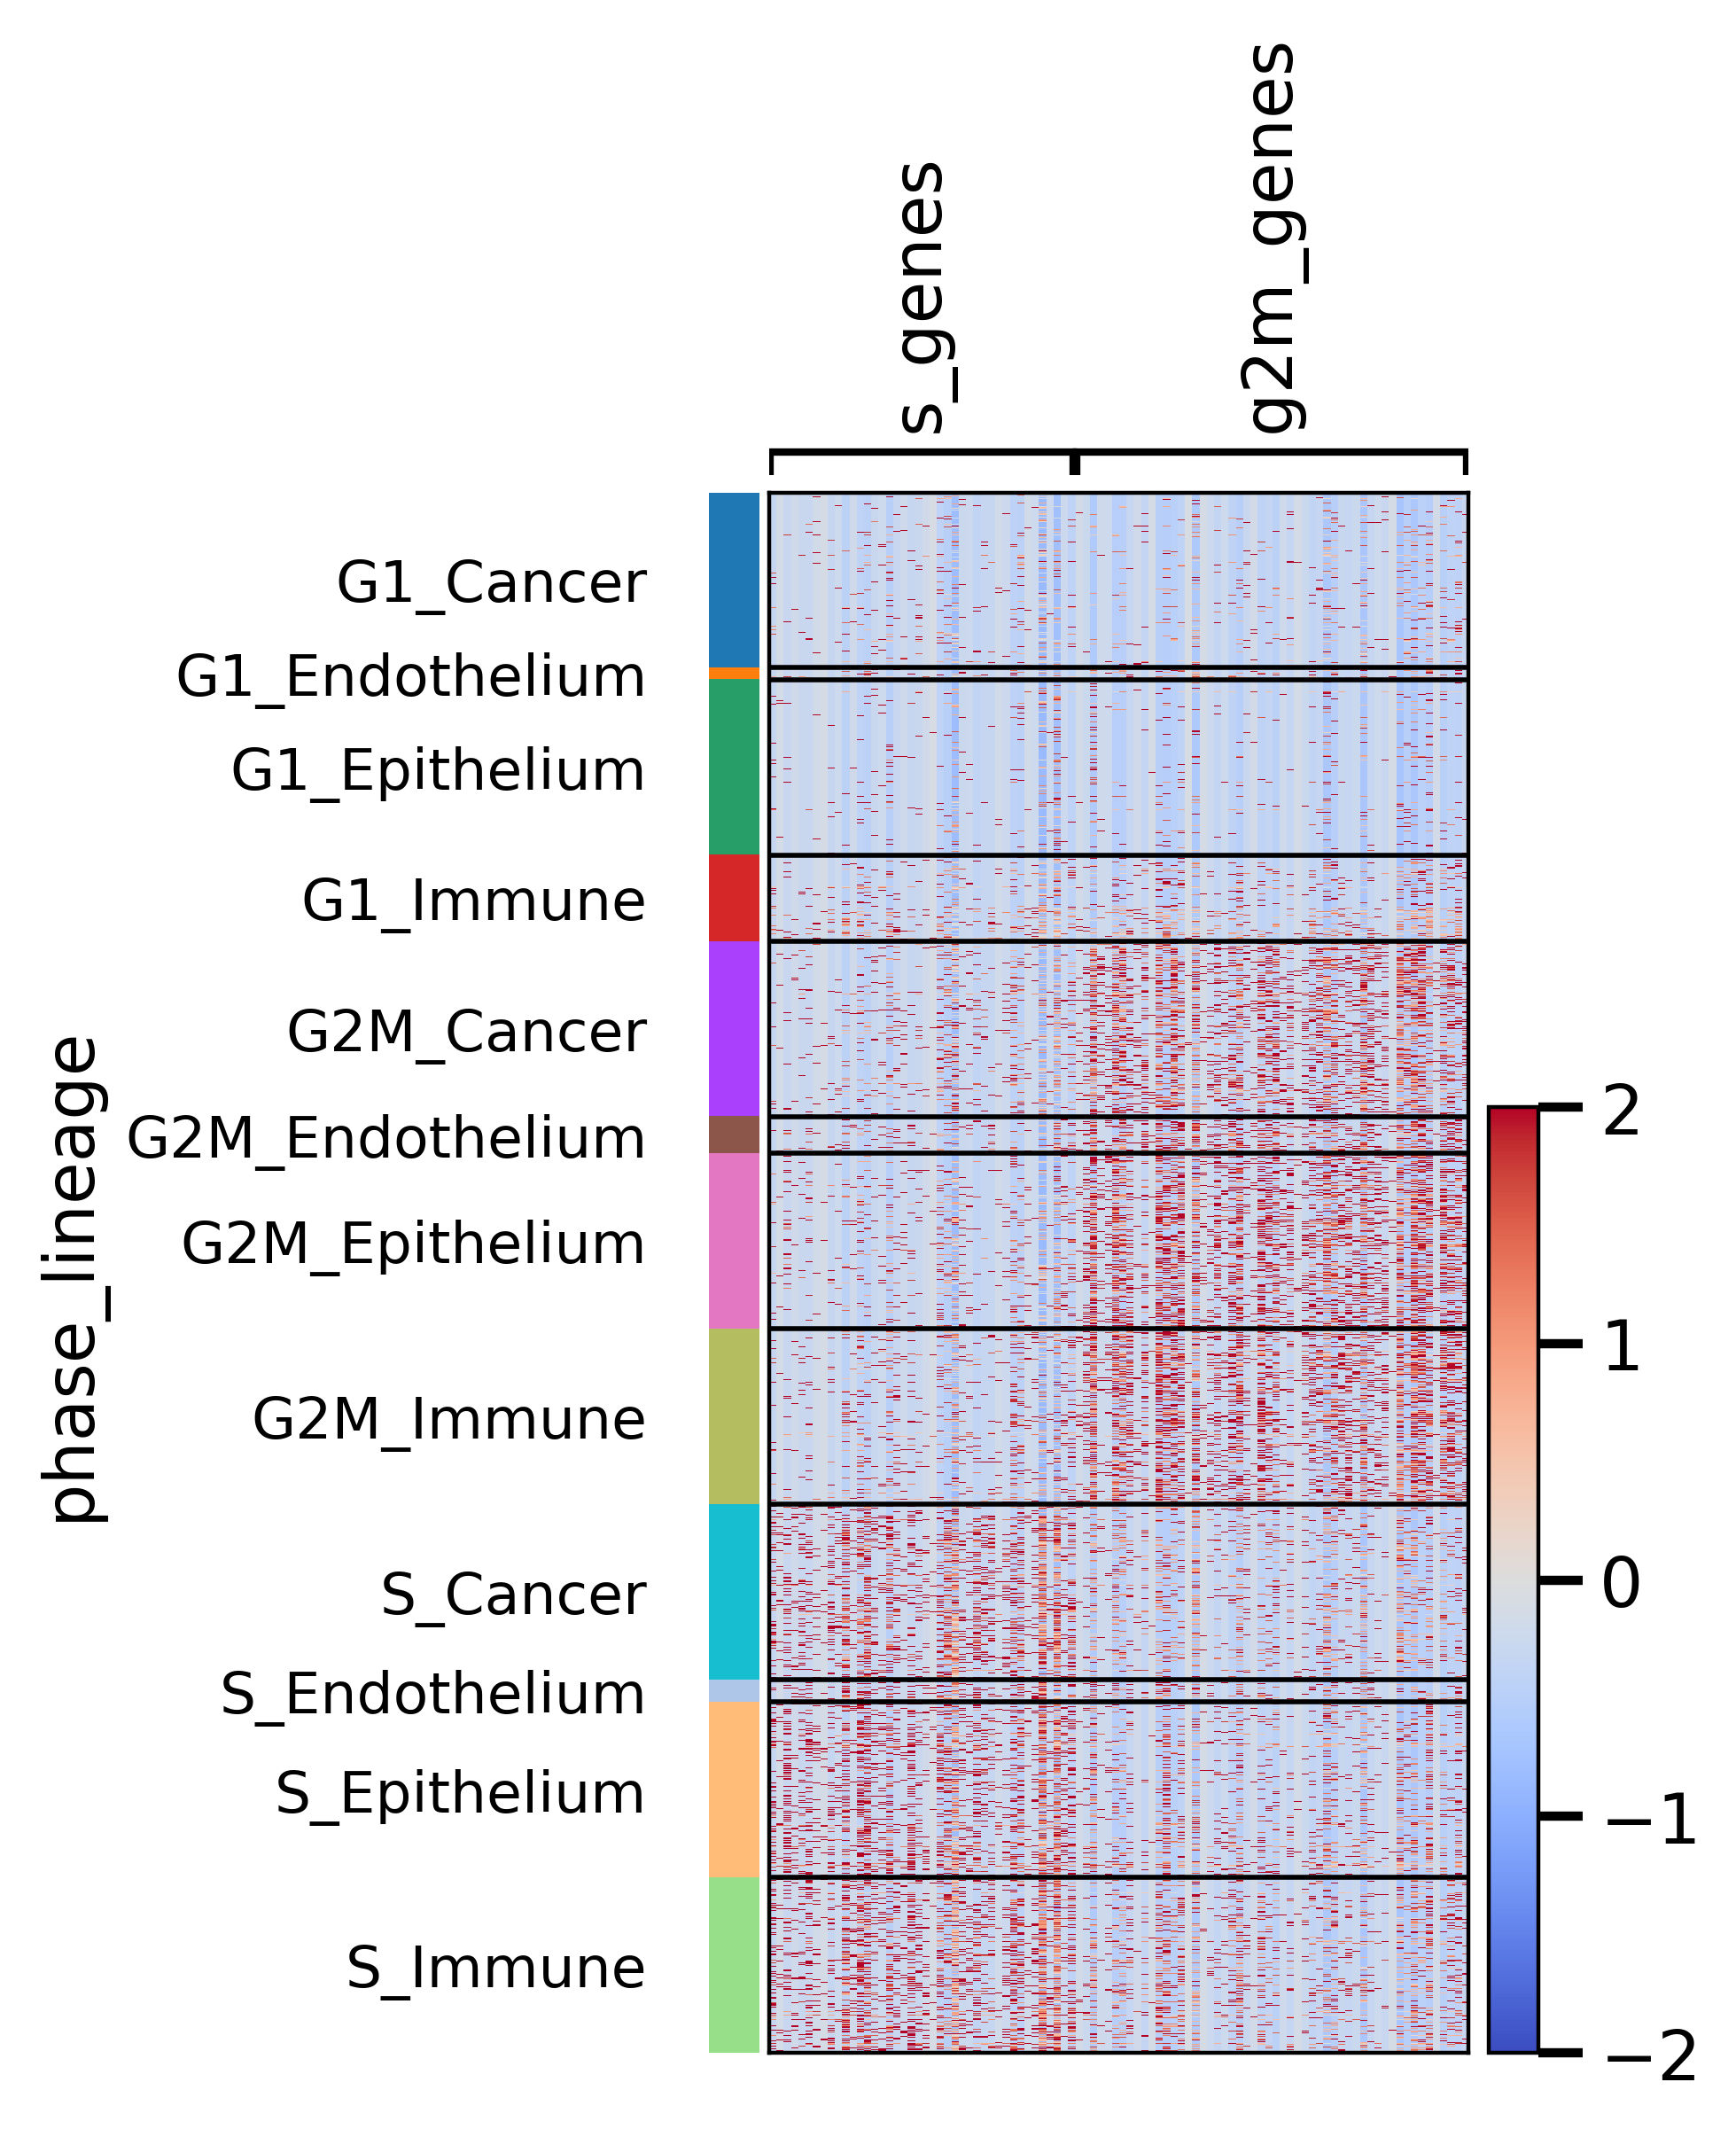

In [59]:
#vmin=-2, vmax=2, 
sc.pl.heatmap(adata_cycle_subset, marker_dict, figsize=[3,6], groupby = 'phase_lineage', use_raw = False, 
              cmap = 'coolwarm', vmax=2, vmin=-2)

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


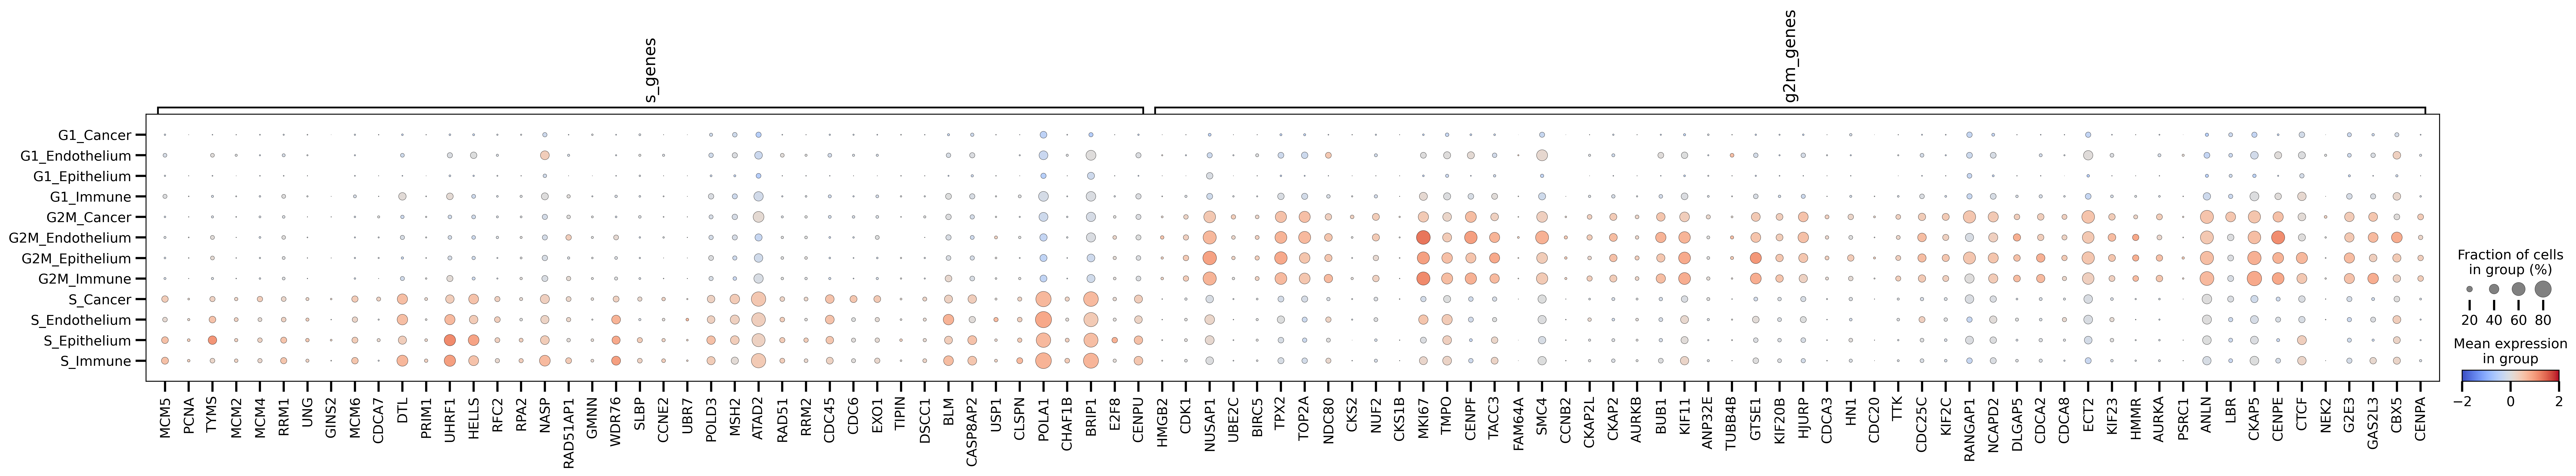

In [60]:
sc.pl.dotplot(adata_cycle_added, marker_dict, groupby = 'phase_lineage', use_raw = False, 
              cmap = 'coolwarm', vmax=2, vmin=-2)

In [18]:
subset_name = 'combined_DGE'
adata = sc.read(subset_name + '.h5ad')

adata_anno = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/adata_all_cell_raw_with_anno_latest.h5ad')
adata_anno = adata_anno[adata.obs.index.tolist(), :]

adata.obs['Type'] = adata_anno.obs['Type']
adata.obs['Celltype'] = adata_anno.obs['Celltype']
adata.obs['cnv_cluster_type'] = adata_anno.obs['cnv_cluster_type']
adata.obs['cancer_type'] = adata_anno.obs['cancer_type']
adata.obs['lineage'] = adata_anno.obs['lineage']
adata.obs['patient_id'] = adata_anno.obs['patient_id']

adata.obs['tissue'] = adata.obs['sample'].str.split('_', expand=True)[2]

adata.write(subset_name + '.h5ad')

# Common Cell Cycle Gene (Cancer & Epithelium)

In [5]:
# adata for conserved marker

for each_lineage in ['Cancer', 'Epithelium']:

    subset_name = 'combined_DGE'
    adata_cycle_added = sc.read(subset_name + '.h5ad')

    adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/adata_all_cell_raw_with_anno_latest.h5ad')
    adata = adata[adata_cycle_added.obs.index.tolist(), :]
    
    adata.obs['S_score'] = adata_cycle_added.obs['S_score']
    adata.obs['G2M_score'] = adata_cycle_added.obs['G2M_score']
    adata.obs['phase'] = adata_cycle_added.obs['phase']
    
    adata = adata[adata.obs['lineage'] == each_lineage]
        
    adata.write('cnv_high_low_common_conserved_marker_each_phase/' + each_lineage + '_for_common_conserved_marker.h5ad')

    adata.obs[['phase', 'cancer_type']].to_csv('cnv_high_low_common_conserved_marker_each_phase/' + each_lineage + '_for_common_conserved_marker.csv')

/tmp/ipykernel_30941/3959016627.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = adata_cycle_added.obs['S_score']
/tmp/ipykernel_30941/3959016627.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = adata_cycle_added.obs['S_score']


In [173]:
p_val_cutoff = 0.05
avg_log2FC_cutoff = 0.5
pct_1_cutoff = 0.1
pct_difference_cutoff = 0

all_marker_all = pd.DataFrame()

for each_lineage in ['Cancer', 'Epithelium']:
    
    for each_phase in ['G1', 'S', 'G2M']:
        
        each_tissue_marker = pd.read_csv('cnv_high_low_common_conserved_marker_each_phase/' + each_lineage + '_' + each_phase + '.markers.csv', index_col=0)

        if 'minimump_p_val' in each_tissue_marker.columns.tolist():

            each_tissue_marker[each_tissue_marker['minimump_p_val'] < p_val_cutoff]

#        for each_column in [s for s in each_tissue_marker.columns.tolist() if '_p_val_adj' in s]:

#            each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] < p_val_cutoff]

        for each_column in [s for s in each_tissue_marker.columns.tolist() if '_avg_log2FC' in s]:

            each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > avg_log2FC_cutoff]

        for each_column in [s for s in each_tissue_marker.columns.tolist() if '_pct.1' in s]:

            each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > pct_1_cutoff]

        for each_cancer in ["BRCA", "COAD_READ", "ESCA", "HCC", "ICC", "LUAD", "STAD"]:

            if each_cancer + '_pct.1' in each_column:

                for each_gene in each_tissue_marker.index.tolist():

                    if each_tissue_marker.loc[each_gene, each_cancer + '_pct.1'] - each_tissue_marker.loc[each_gene, each_cancer + '_pct.2'] < pct_difference_cutoff:

                        each_tissue_marker = each_tissue_marker.drop(each_gene)        

        each_tissue_marker['phase'] = each_phase
        each_tissue_marker['lineage'] = each_lineage
        each_tissue_marker['gene'] = each_tissue_marker.index
        
        all_marker_all = pd.concat([each_tissue_marker, all_marker_all], axis=0)
        
            

In [188]:
common_S = list(set(all_marker_all[(all_marker_all['lineage'] == 'Cancer') & (all_marker_all['phase'] == 'S')]['gene'].tolist()).intersection(set(all_marker_all[(all_marker_all['lineage'] == 'Epithelium') & (all_marker_all['phase'] == 'S')]['gene'].tolist())))
common_G2M = list(set(all_marker_all[(all_marker_all['lineage'] == 'Cancer') & (all_marker_all['phase'] == 'G2M')]['gene'].tolist()).intersection(set(all_marker_all[(all_marker_all['lineage'] == 'Epithelium') & (all_marker_all['phase'] == 'G2M')]['gene'].tolist())))

In [194]:
cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# Gene alias
s_genes.append('CENPU')
s_genes.remove('MLF1IP')

/tmp/ipykernel_4081/3329920036.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt' mode='r' encoding='UTF-8'>
  cell_cycle_genes = [x.strip() for x in open('/public/home/guogjgroup/ggj/matq_analysis/scripts_share/jikai/cell_cycle_gene/regev_lab_cell_cycle_genes.txt')]


In [195]:
list(set(common_S).intersection(set(s_genes)))

['ATAD2', 'DTL', 'POLA1', 'BRIP1', 'UHRF1']

In [196]:
list(set(common_G2M).intersection(set(g2m_genes)))

['TPX2', 'GTSE1', 'MKI67', 'CKAP5', 'CENPF']

In [6]:
subset_name = 'combined_DGE'
adata_cycle_added = sc.read(subset_name + '.h5ad')

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/adata_all_cell_raw_with_anno_latest.h5ad')
adata = adata[adata_cycle_added.obs.index.tolist(), :]

adata.obs['S_score'] = adata_cycle_added.obs['S_score']
adata.obs['G2M_score'] = adata_cycle_added.obs['G2M_score']
adata.obs['phase'] = adata_cycle_added.obs['phase']

adata = adata[adata.obs['lineage'].isin(['Cancer', 'Epithelium'])]

adata.obs['lineage'] = adata.obs['lineage'].astype(str)
adata.obs['phase'] = adata.obs['phase'].astype(str)
adata.obs['phase_lineage'] = adata.obs['phase'] + '_' + adata.obs['lineage']

adata_cycle = adata.copy()

#adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/adata_all_cell_raw_with_anno_latest.h5ad')
#adata = adata[adata.obs['lineage'] == 'Epithelium']
#
#epi_all_list = adata.obs.index.tolist()
#epi_other_list = list(set(epi_all_list).difference(set(adata_cycle_added.obs.index.tolist())))
#epi_other = adata[epi_other_list, :].copy()
#epi_other.obs['phase_lineage'] = 'Ref_Epithelium'
#
#adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cnv_high_epi_harmony_anno_latest.h5ad')
#adata = adata[adata.obs['leiden'] != '1']
#adata = adata[adata.obs['leiden'] != '6']
#cancer_other = adata.copy()
#cancer_other.obs['phase_lineage'] = 'Ref_Cancer'
#
#adata_display = sc.AnnData.concatenate(adata_cycle, epi_other, cancer_other,
#                                       join = "outer", fill_value = 0, index_unique = None)
#
#sc.pp.normalize_total(adata_display)
#sc.pp.log1p(adata_display)
#sc.pp.scale(adata_display)

sc.pp.normalize_total(adata_cycle)
sc.pp.log1p(adata_cycle)
sc.pp.scale(adata_cycle)

/tmp/ipykernel_26409/1402829522.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = adata_cycle_added.obs['S_score']
/tmp/ipykernel_26409/1402829522.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['lineage'] = adata.obs['lineage'].astype(str)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [7]:
adata_cycle.obs['phase_lineage'] = adata_cycle.obs['phase_lineage'].astype('str')
adata_cycle.obs['phase_lineage'] = adata_cycle.obs['phase_lineage'].str.split('_', expand=True)[0] + ' (' + adata_cycle.obs['phase_lineage'].str.split('_', expand=True)[1] + ')'


In [8]:
adata_cycle.obs['phase_lineage'] = adata_cycle.obs['phase_lineage'].astype('category')
adata_cycle.obs['phase_lineage'] = adata_cycle.obs['phase_lineage'].cat.reorder_categories(['G1 (Cancer)', 'G1 (Epithelium)',
                                                                                    'S (Cancer)', 'S (Epithelium)', 
                                                                                    'G2M (Cancer)', 'G2M (Epithelium)'])

In [9]:
marker_dict = {}

marker_dict['S'] = ['ATAD2', 'DTL', 'POLA1', 'BRIP1', 'UHRF1']
marker_dict['G2M'] = ['TPX2', 'GTSE1', 'MKI67', 'CKAP5', 'CENPF']

#marker_dict['S'] = ['DTL', 'BRIP1', 'UHRF1', 'ATAD2', 'NASP', 'POLA1']
#marker_dict['G2M'] = ['GTSE1', 'TPX2', 'LBR', 'ECT2', 'NCAPD2', 'MKI67', 'CENPF', 'CDC25C', 'CKAP5',
#                             'NUSAP1', 'KIF20B']
#marker_dict['G2M (novel ncRNA)'] = ['RP11-120D5.1']

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(
/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


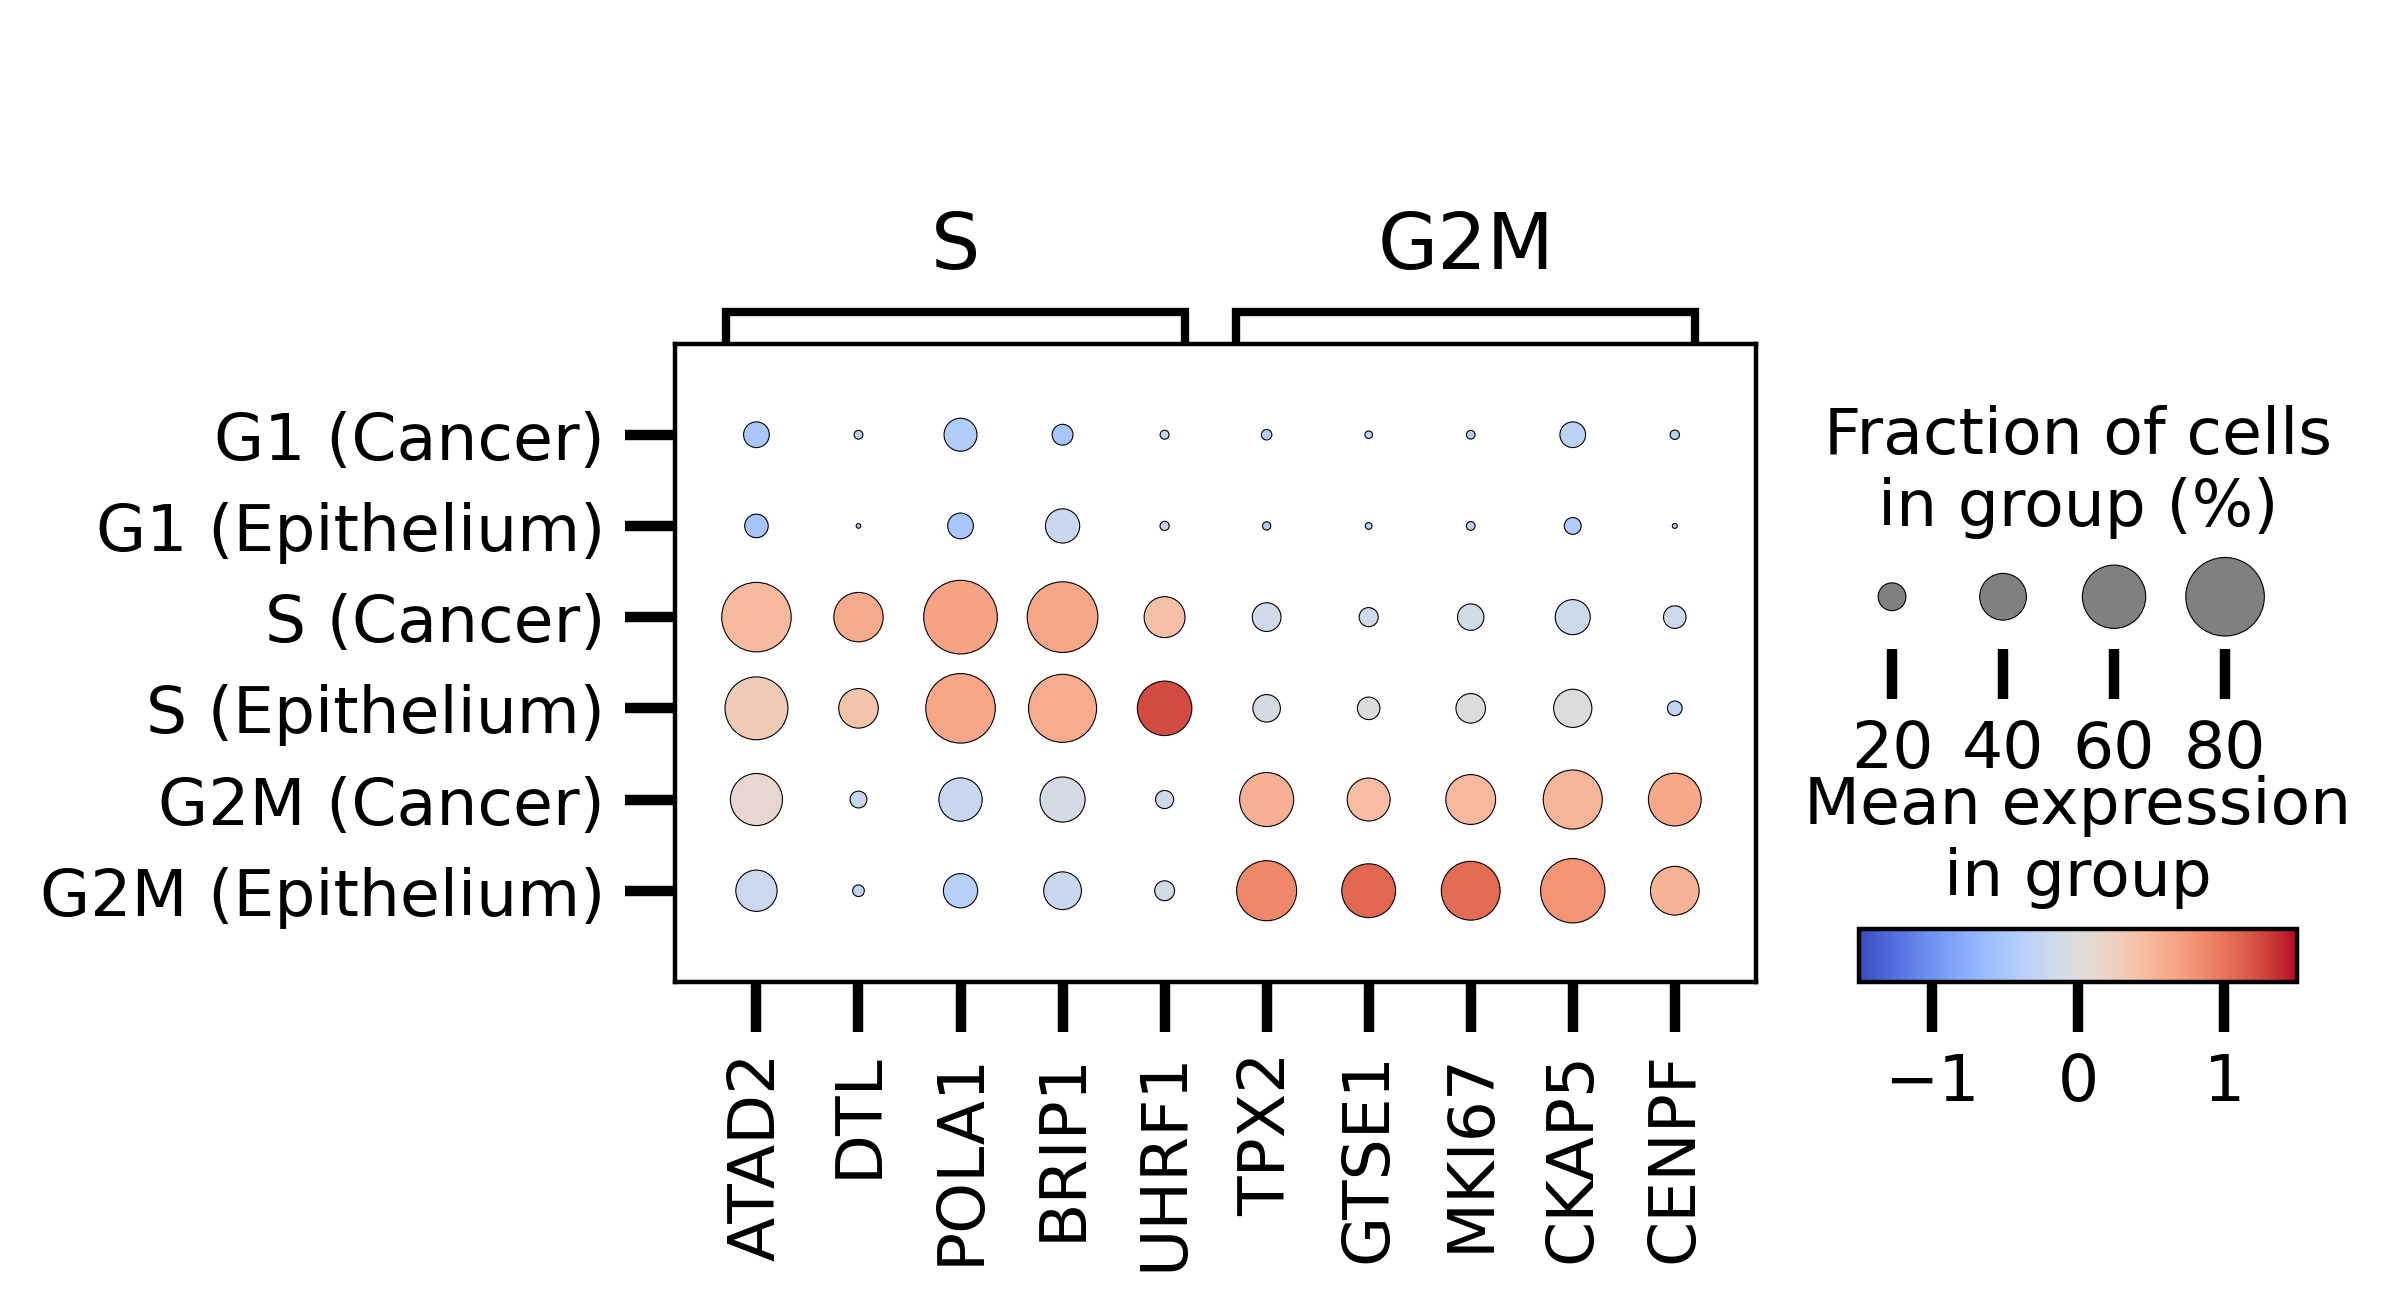

In [10]:
sc.pl.dotplot(adata_cycle, marker_dict, groupby = 'phase_lineage', vmin=-1.5, vmax=1.5, use_raw = False, 
              cmap = 'coolwarm', dot_max=0.8, save='cell_cycle_marker_cancer_epithelium.pdf')

#vmin=-1.5, vmax=1.5